# 'Unhappy hard-workers' and 'unhappy champions': how to make them happy?

## 📖 Background
You work for the human capital department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

## 💾 The data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

from sklearn import tree 
import graphviz
from mpl_toolkits.mplot3d import Axes3D

## EDA

Let' start with preprocessing and exploratory data analysis.

In [50]:
df = pd.read_csv('./data/employee_churn_data.csv')
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 9540 entries, 0 to 9539

Data columns (total 10 columns):

 #   Column         Non-Null Count  Dtype  

---  ------         --------------  -----  

 0   department     9540 non-null   object 

 1   promoted       9540 non-null   int64  

 2   review         9540 non-null   float64

 3   projects       9540 non-null   int64  

 4   salary         9540 non-null   object 

 5   tenure         9540 non-null   float64

 6   satisfaction   9540 non-null   float64

 7   bonus          9540 non-null   int64  

 8   avg_hrs_month  9540 non-null   float64

 9   left           9540 non-null   object 

dtypes: float64(4), int64(3), object(3)

memory usage: 745.4+ KB


**Which department has the highest employee turnover? Which one has the lowest?**

In [52]:
df.department.value_counts()

sales          1883
retail         1541
operations     1522
engineering    1516
marketing       802
support         735
admin           423
finance         402
logistics       360
IT              356
Name: department, dtype: int64

In [53]:
round(pd.crosstab(df.department, df.left, normalize = 0)*100, 1).sort_values(by = 'yes', ascending = False).reset_index()

left,department,no,yes
0,IT,69.1,30.9
1,logistics,69.2,30.8
2,retail,69.4,30.6
3,marketing,69.7,30.3
4,engineering,71.2,28.8
5,support,71.2,28.8
6,operations,71.4,28.6
7,sales,71.5,28.5
8,admin,71.9,28.1
9,finance,73.1,26.9


As we can see, there is the highest employee turnover (higher than 30%) in IT, logistics, retail and marketing departments, and the lowest (around 27%) is in the finance department.

Taking into account the sizes of the departments, the turnover is especially alarming in IT and logistics.

In [54]:
df['salary'] = df['salary'].replace({'low': 1, 'medium': 2, 'high': 3})
df['left'] = df['left'].replace({'no': 0, 'yes': 1})

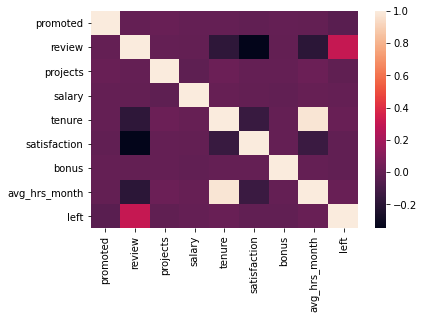

In [55]:
sns.heatmap(df.corr());

There is a strong linear correlation between the 'tenure' and 'avg_hrs_month' features, as well as a significant correlation of the 'review' feature with the target variable. 

'Review' may be an important predictor.

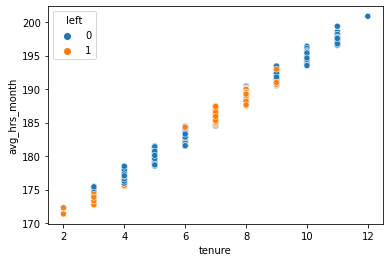

In [56]:
sns.scatterplot(x='tenure', y='avg_hrs_month', hue='left', data=df);

There is a linear relationship between the features. We probably should get rid of one of these. (At least in case we use linear algorithms).

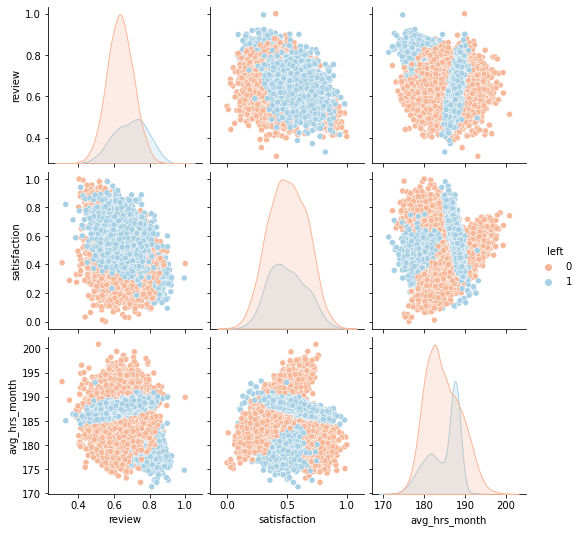

In [57]:
sns.pairplot(df[['review', 'satisfaction', 'avg_hrs_month', 'left']], hue = 'left', palette = 'RdBu');

We can see obvious patterns in the data. All three features seem to be important predictors of the target variable. 

We can also notice that the data does not seem to be linearly separable.

## ML models and feature importance

We'll use one of the most efficient algorithms for tabular data: gradient boosting based on decision trees. Let's train the model and evaluate the importance of the features. 

We'll exclude the 'department' feature, since we need to identify common criteria that affect the turnover of employees, regardless of the department.

Let's tune the optimal hyperparameters using cross-validation and train the model.

In [58]:
X = df.drop(['left', 'department'], axis = 1)
y = df.left

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, stratify = y, random_state = 123)

In [60]:
%%time

# Create the parameter grid
param_grid = {'loss': ['deviance', 'exponential'], 'criterion': ['friedman_mse', 'squared_error'], 'max_features': ['sqrt', None], \
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8], 'n_estimators': [200, 400, 600], \
              'min_samples_leaf': [50, 60, 70, 80, 100, 120], 'max_depth': [3, 5, 7, 10, 12, 14]} 

# Create a random search object
rs_GBC = RandomizedSearchCV(
    estimator = GradientBoostingClassifier(),
    param_distributions = param_grid,
    n_iter = 20, random_state = 123,
    scoring='roc_auc', n_jobs=-1, cv = 5, refit=True)

# Fit to the training data
rs_GBC.fit(X_train, y_train)

CPU times: user 1.62 s, sys: 25.7 ms, total: 1.65 s

Wall time: 48.6 s


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.4, 0.6, 0.8],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [3, 5, 7, 10, 12, 14],
                                        'max_features': ['sqrt', None],
                                        'min_samples_leaf': [50, 60, 70, 80,
                                                             100, 120],
                                        'n_estimators': [200, 400, 600]},
                   random_state=123, scoring='roc_auc')

We'll use the metrics that take into account the accuracy of predicting objects of both positive and negative classes, although recall score is primary for the task.

In [61]:
print('F1 score, train:', round(f1_score(y_train, rs_GBC.predict(X_train)), 3), ' / ', \
      'F1_score, test:', round(f1_score(y_test, rs_GBC.predict(X_test)), 3))
print('ROC AUC score, train:', round(roc_auc_score(y_train, rs_GBC.predict_proba(X_train)[:,1]), 3),  ' / ', \
      'ROC AUC score, test:', round(roc_auc_score(y_test, rs_GBC.predict_proba(X_test)[:,1]), 3))
print('Recall score, train:', round(recall_score(y_train, rs_GBC.predict(X_train)), 3), '/', \
      'Recall score, test:', round(recall_score(y_test, rs_GBC.predict(X_test)), 3))
print('Confusion matrix:')
print(confusion_matrix(y_test, rs_GBC.predict(X_test)))

F1 score, train: 0.85  /  F1_score, test: 0.759

ROC AUC score, train: 0.972  /  ROC AUC score, test: 0.925

Recall score, train: 0.81 / Recall score, test: 0.711

Confusion matrix:

[[945  68]

 [121 297]]


In [62]:
rs_GBC.best_params_

{'n_estimators': 200,
 'min_samples_leaf': 70,
 'max_features': 'sqrt',
 'max_depth': 7,
 'loss': 'deviance',
 'learning_rate': 0.1,
 'criterion': 'friedman_mse'}

In [63]:
pd.Series(rs_GBC.best_estimator_.feature_importances_, index = X_train.columns).sort_values(ascending = False)

satisfaction     0.336657
review           0.279696
avg_hrs_month    0.260112
tenure           0.113539
projects         0.004004
salary           0.003233
bonus            0.001728
promoted         0.001031
dtype: float64

The most important features are: 'satisfaction', 'avg_hrs_month', 'review'.

Let's train a simpler and more interpretable model (decision tree), using these features.

In [64]:
X_train_3f = X_train[['satisfaction', 'avg_hrs_month', 'review']]
X_test_3f = X_test[['satisfaction', 'avg_hrs_month', 'review']]

In [65]:
%%time

# Create the parameter grid
param_grid = {'criterion': ['gini', 'entropy'], 'min_samples_leaf': [80, 100, 150, 300, 500], 'max_depth': [3, 4, 5, 7, 10, 12]} 

# Create a random search object
rs_dt = RandomizedSearchCV(
    estimator = DecisionTreeClassifier(class_weight = 'balanced'),
    param_distributions = param_grid,
    n_iter = 20, random_state = 123,
    scoring='roc_auc', n_jobs=-1, cv = 5, refit=True)

# Fit to the training data
rs_dt.fit(X_train_3f, y_train)

CPU times: user 84.7 ms, sys: 5.58 ms, total: 90.3 ms

Wall time: 949 ms


RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(class_weight='balanced'),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5, 7, 10, 12],
                                        'min_samples_leaf': [80, 100, 150, 300,
                                                             500]},
                   random_state=123, scoring='roc_auc')

In [66]:
print('F1 score, train:', round(f1_score(y_train, rs_dt.predict(X_train_3f)), 3), ' / ', \
      'F1_score, test:', round(f1_score(y_test, rs_dt.predict(X_test_3f)), 3))
print('ROC AUC score, train:', round(roc_auc_score(y_train, rs_dt.predict_proba(X_train_3f)[:,1]), 3), ' / ', \
      'ROC AUC score, test:', round(roc_auc_score(y_test, rs_dt.predict_proba(X_test_3f)[:,1]), 3))
print('Recall score, train:', round(recall_score(y_train, rs_dt.predict(X_train_3f)), 3), '/', \
      'Recall score, test:', round(recall_score(y_test, rs_dt.predict(X_test_3f)), 3))
print('Confusion matrix:')
print(confusion_matrix(y_test, rs_dt.predict(X_test_3f)))

F1 score, train: 0.758  /  F1_score, test: 0.734

ROC AUC score, train: 0.925  /  ROC AUC score, test: 0.903

Recall score, train: 0.842 / Recall score, test: 0.821

Confusion matrix:

[[840 173]

 [ 75 343]]


The results of this simpler model are comparable to those of the previous model. Actually, the model is less overfitted and recall score is higher.

In [67]:
rs_dt.best_params_

{'min_samples_leaf': 80, 'max_depth': 7, 'criterion': 'gini'}

Let's visualize the tree.

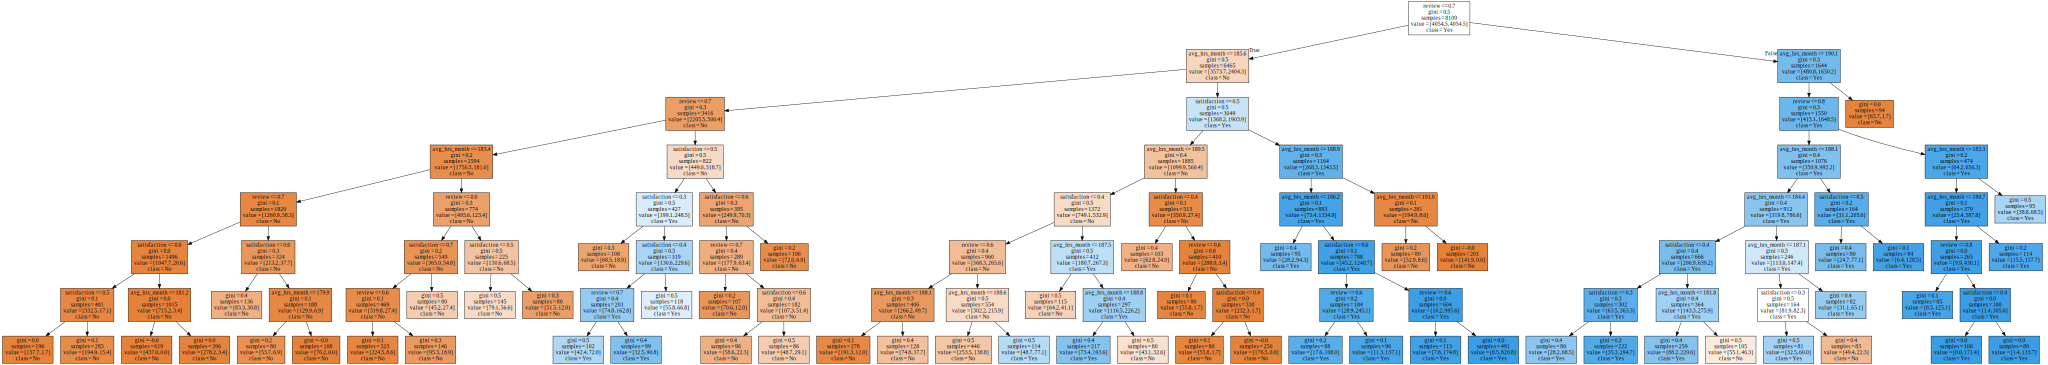

In [68]:
tree_viz = tree.export_graphviz(rs_dt.best_estimator_, out_file=None, feature_names = X_train_3f.columns, \
                               precision = 1, class_names = ['No', 'Yes'], filled = True)

graph = graphviz.Source(tree_viz)
display(graph)

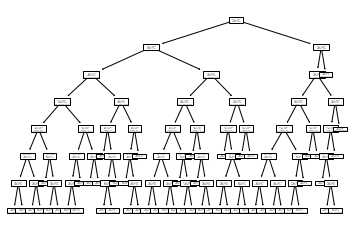

In [69]:
tree.plot_tree(rs_dt.best_estimator_)
plt.show()

The model's performance is high enough, but it is still too difficult to interpret.

## Сlustering

Let's try to identify individual clusters corresponding to the positive class, which could be easily interpreted.

In [70]:
X_new = X[['satisfaction', 'avg_hrs_month', 'review']]

In [71]:
scaler = MinMaxScaler()
X_scaled = X_new.copy()

X_scaled['avg_hrs_month'] = scaler.fit_transform(boxcox(X_scaled['avg_hrs_month'])[0].reshape(-1, 1))

In [72]:
df_new = pd.concat([X_new, y], axis = 1)
df_scaled = pd.concat([X_scaled, y], axis = 1)

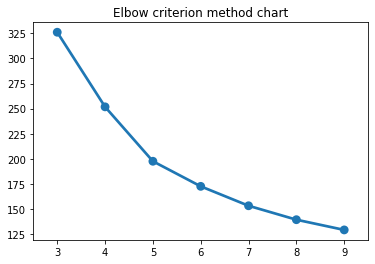

In [73]:
sse = {}

# Fit KMeans algorithm on k values between 1 and 9
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, algorithm = 'full', random_state=123)
    kmeans.fit(df_scaled)
    sse[k] = kmeans.inertia_

plt.title('Elbow criterion method chart')

sns.pointplot(x=list(sse.keys())[2:], y=list(sse.values())[2:])
plt.show()

In [74]:
sse

{1: 2472.5431525962044,
 2: 494.5069575153796,
 3: 325.9932319798308,
 4: 251.79675292992985,
 5: 197.669790502183,
 6: 172.71783959680747,
 7: 153.40833910785344,
 8: 139.54730301459725,
 9: 129.38462615116694}

7 clusters seem to be a good choice.

In [75]:
kmeans = KMeans(n_clusters=7, algorithm = 'full', random_state=123)

# Fit the model on the pre-processed dataset
kmeans.fit(df_scaled)

# Assign the generated labels to a new column
df_scaled_kmeans = df_scaled.assign(segment = kmeans.labels_)
df_new_kmeans = df_new.assign(segment = kmeans.labels_)

         satisfaction  avg_hrs_month  review  left

segment                                           

0                0.41           0.57    0.68     1

1                0.54           0.40    0.67     0

2                0.72           0.35    0.59     0

3                0.66           0.57    0.62     1

4                0.48           0.67    0.63     0

5                0.31           0.50    0.65     0

6                0.40           0.33    0.78     1


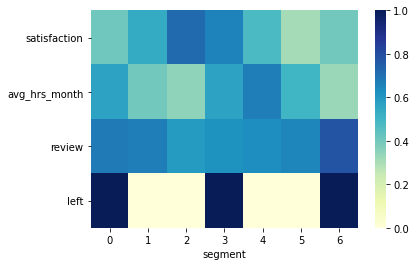

In [76]:
# Group by the segment label and calculate average column values
kmeans_avg = df_scaled_kmeans.groupby(['segment']).mean().round(2)

print(kmeans_avg)

# Create a heatmap on the average column values per each segment
sns.heatmap(kmeans_avg.T, cmap='YlGnBu')

plt.show()

In [77]:
df_new_kmeans.groupby(['segment']).agg(['min', 'median', 'max']).round(2)

satisfaction              avg_hrs_month                 review         \
                 min median   max           min  median     max    min median   
segment                                                                         
0               0.10   0.43  0.60        182.70  187.86  193.26   0.45   0.68   
1               0.35   0.55  0.67        175.45  182.20  186.19   0.51   0.67   
2               0.57   0.70  1.00        172.30  180.76  187.28   0.40   0.59   
3               0.50   0.66  0.98        176.75  187.29  189.84   0.33   0.62   
4               0.30   0.47  0.76        185.20  189.86  200.86   0.31   0.63   
5               0.00   0.32  0.46        175.17  185.20  190.12   0.35   0.65   
6               0.09   0.40  0.71        171.37  180.58  184.52   0.64   0.78   

              left             
          max  min median max  
segment                        
0        0.90    1      1   1  
1        0.86    0      0   0  
2        0.75    0      0   0  
3        0.84    1      1   1  
4        1.00    0      0   0  
5        0.88    0      0   0  
6        0.99    1      1   1

We are interested in the clusters corresponding to the positive class. Now we can identify distinct categories among the employees who left the company.
_______________

**Segment №0**: the employees who work pretty hard and have got high score in their last evaluation, but feel unhappy with their job.

Let's call them the **'unhappy hard-workers'**. 
They probably feel overwhelmed with their job duties. 

Some of them could probably become happier if they got a vacation, an assistant, more interesting tasks or projects, promotion or additional bonus.
________________

**Segment №3**: the employees who seem happy with their jobs, but have relatively low score. 

Some of them probably didn't leave the company but were fired. 

They are probably not the segment the company is going to struggle for.
_______________

**Segment №6**: the employees who have very good reviews, who don't seem overwhelmed, but still are unhappy with their jobs. 

Let's call them **'unhappy champions'**.

This could be related with lack of motivation or interest in their job duties. They also can feel under-estimated. 

Promotion or new interesting projects/tasks would probably help some of them.
______________

**The most important segments for the company are obviously segments #0 and #6.** 
These are the most effective employees that the company wants to retain.

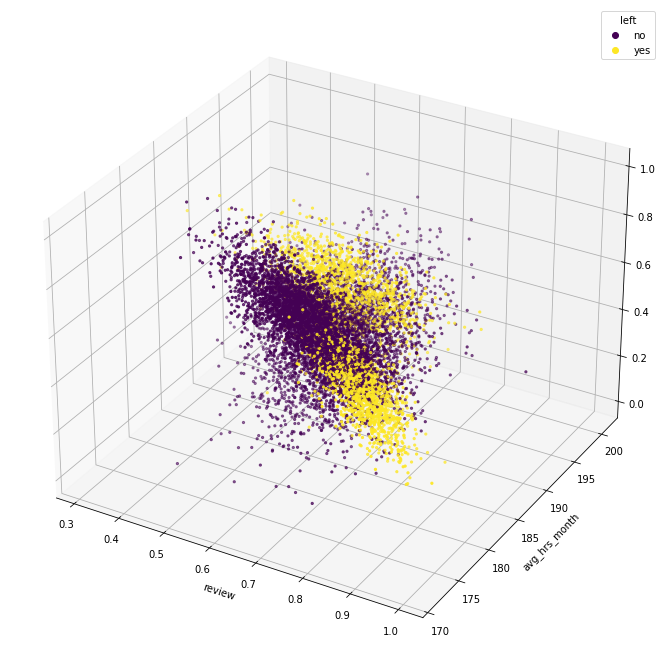

In [78]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection='3d') 
scatter = ax.scatter(df_new_kmeans['review'], df_new_kmeans['avg_hrs_month'],  df_new_kmeans['satisfaction'],  \
           c = df_scaled_kmeans['left'], s = 5)
plt.legend(handles=scatter.legend_elements()[0], 
           labels = ['no', 'yes'],
           title="left")
plt.xlabel('review')
plt.ylabel('avg_hrs_month');

As we can see, there are clearly distinguishable subgroups among the employees who left the company. 

Let's visualize the 3 clusters we have got:

In [79]:
segments = df_new_kmeans[df_new_kmeans['segment'].isin([0, 3, 6])]

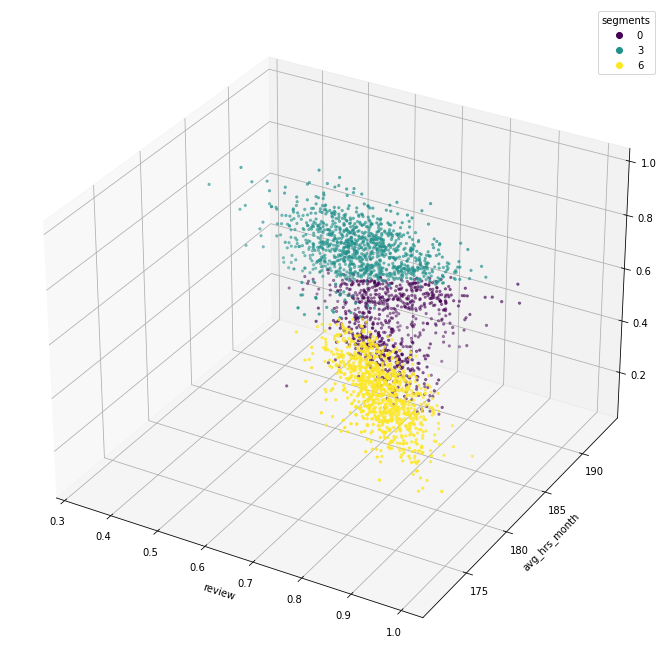

In [80]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection='3d') 
scatter = ax.scatter(segments['review'], segments['avg_hrs_month'], segments['satisfaction'], \
           c = segments['segment'], s = 5)
plt.legend(handles=scatter.legend_elements()[0], 
           labels = [0, 3, 6],
           title="segments")
plt.xlabel('review')
plt.ylabel('avg_hrs_month');

In [81]:
s0 = df_new_kmeans[df_new_kmeans['segment'] == 0]
s3 = df_new_kmeans[df_new_kmeans['segment'] == 3]
s6 = df_new_kmeans[df_new_kmeans['segment'] == 6]
print('Size of the segment 0:', len(s0))
print('Size of the segment 3:', len(s3))
print('Size of the segment 6:', len(s6))

Size of the segment 0: 760

Size of the segment 3: 1036

Size of the segment 6: 988


We can see quite distinct segments of similar sizes among the employees who left the company.

Let's find 95% confidence intervals for each segment and each feature.

In [82]:
s0.name = 'Segment 0'
s3.name = 'Segment 3'
s6.name = 'Segment 6'

In [83]:
def find_ci(segments, features):
    for s in segments:
        print('95% confidence intervals for {}:'.format(s.name))
        for i in features:
            print('{}:'.format(i), [round(np.percentile(s[i], 2.5), 2), round(np.percentile(s[i], 97.5), 2)])
        print()

In [84]:
find_ci([s0, s3, s6], ['satisfaction', 'avg_hrs_month', 'review'])

95% confidence intervals for Segment 0:

satisfaction: [0.2, 0.54]

avg_hrs_month: [183.58, 190.0]

review: [0.55, 0.79]



95% confidence intervals for Segment 3:

satisfaction: [0.54, 0.86]

avg_hrs_month: [184.28, 188.74]

review: [0.47, 0.77]



95% confidence intervals for Segment 6:

satisfaction: [0.2, 0.59]

avg_hrs_month: [175.23, 183.72]

review: [0.68, 0.88]




Now, based on the values of the three features, we can identify employees who may wish to quit in the near future. 

There are simple and intuitive criteria that the company's HR team could lean on even without using machine learning models.

In [85]:
def hr_alarm(row):
    if 0.2 <= row['satisfaction'] <= 0.54:
        if 183.58 <= row['avg_hrs_month'] <= 190.0:
            if 0.55 <= row['review'] <= 0.79:
                return 1
            else:
                return 0
        elif 175.23 <= row['avg_hrs_month'] < 183.58:
            if 0.68 <= row['review'] <= 0.88:
                return 1
            else: 
                return 0
        else:
            return 0
    elif 0.54 < row['satisfaction'] <= 0.86:
        if 184.28 <= row['avg_hrs_month'] <= 188.74:
            if 0.47 <= row['review'] <= 0.77:
                return 1
            else:
                return 0
        else:
            return 0
    else:
        return 0

Let's define the new feature 'alarm' based on these criteria.

In [86]:
df_test = df_new.copy()
df_test['alarm'] = df_test.apply(hr_alarm, axis = 1)

In [87]:
df_test

,satisfaction,avg_hrs_month,review,left,alarm
0,0.626759,180.866070,0.577569,0,0
1,0.443679,182.708149,0.751900,0,1
2,0.446823,184.416084,0.722548,0,1
3,0.440139,188.707545,0.675158,0,1
4,0.577607,179.821083,0.676203,0,0
...,...,...,...,...,...
9535,0.543641,188.155738,0.610988,1,1
9536,0.549048,188.176164,0.746887,1,1
9537,0.705425,186.531008,0.557980,1,1
9538,0.607287,187.641370,0.584446,1,1


We can now compare the result of this approach with the ML models that we've trained before, using the same metrics.

In [88]:
print('F1_score, test:', round(f1_score(df_test.left, df_test.alarm), 3))
print('Recall score, test:', round(recall_score(df_test.left, df_test.alarm), 3))
print('Confusion matrix:')
print(confusion_matrix(df_test.left, df_test.alarm))

F1_score, test: 0.607

Recall score, test: 0.861

Confusion matrix:

[[4036 2720]

 [ 388 2396]]


Our simple hand-crafted model is sort of overcautious: it has a lot of false positives. On the other hand, it's able to correctly predict that the employee is going to hand in their notice in 86% of the cases. This is a good result.

We suppose that it would cost much less for the company to spend time dealing with the employees who are presumably going to quit, comparing to losing qualified staff.

For example, the HR can set up automatic sending of detailed questionnaires to employees corresponding to the segments #0 and #6 in order to try to identify the employees who are really unhappy with their current job situation. And then transfer the results to their management for taking further decisions about how to make these employees happy.

We can identify the employees corresponding to the segments #0 and #6 like this:

In [89]:
def hr_alarm_segments(row):
    if 0.2 <= row['satisfaction'] <= 0.54:
        if 183.58 <= row['avg_hrs_month'] <= 190.0:
            if 0.55 <= row['review'] <= 0.79:
                return 'segment 0'
            else:
                return 0
        elif 175.23 <= row['avg_hrs_month'] < 183.58:
            if 0.68 <= row['review'] <= 0.88:
                return 'segment 6'
            else: 
                return 0
        else:
            return 0
    elif 0.54 < row['satisfaction'] <= 0.86:
        if 184.28 <= row['avg_hrs_month'] <= 188.74:
            if 0.47 <= row['review'] <= 0.77:
                return 'segment 3'
            else:
                return 0
        else:
            return 0
    else:
        return 0

In [90]:
df_test['alarm_segment'] = df_test.apply(hr_alarm_segments, axis = 1)

In [91]:
len(df_test[(df_test.alarm_segment == 'segment 0') & (df_test.left == 1)])

697

In [92]:
len(df_test[(df_test.alarm_segment == 'segment 6') & (df_test.left == 1)])

796

The simplest human interpretable model was able to correctly identify almost 700 employees of segment #0 and almost 800 employees of segment #6. 

Those 1,500 people actually quit and caused loss for the company. 

If we could have known in advance that they were going to leave, we could have taken action to prevent it, saving a lot of money for the company.

## Resume

- We've studied the data provided and found out which departments have the highest employee turnover. Based on the analysis of features, we've suggested which features would be the most important for our task.

- We've trained the machine learning model, evaluated the importance of different features and chose the most important ones. Then we've trained a simpler model on these chosen features and got comparable performance.

- Finally, we've used clustering method to identify subgroups of the employees who left the company. Thus we could determine the simplest and most interpretable criteria by which an employee can be classified as being at a "risk group":
__________
**Segment 0 ('unhappy hard-workers')**:

    satisfaction: [0.2, 0.54]

    avg_hrs_month: [183.58, 190.0]

    review: [0.55, 0.79]

__________
**Segment 6 ('unhappy champions')**:

    satisfaction: [0.2, 0.59]

    avg_hrs_month: [175.23, 183.72]

    review: [0.68, 0.88]

______________
- We've come up with some recommendations about dealing with those employees in order to reduce employee turnover. This should be a good start point for the further work of HR team of the company:
__________
**Segment 0 ('unhappy hard-workers')**:

    Some of them could probably become happier if they got a vacation, an assistant, more interesting tasks or projects, promotion or additional bonus.

__________
**Segment 6 ('unhappy champions')**:

    Promotion or new interesting projects/tasks would probably help some of these employees.